# Inference of hierarchical exponential model parameters

In [4]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}, \sigma _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(y | \mathrm{e}^{\mu}, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, \sigma ^2 _{\mathrm{pop}}).
$$

# Synthesise data

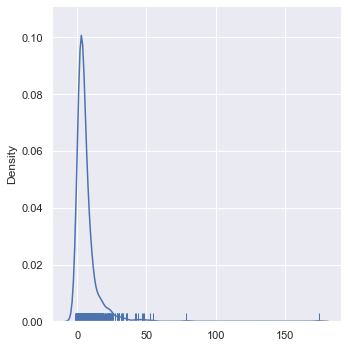

In [2]:
np.random.seed(42)
n_ids = 1000
true_parameters = [1.3, 1, 1]  # pop mean log, pop std. log, noise log
means = np.exp(np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids))
data = means + np.random.normal(loc=0, scale=true_parameters[2], size=n_ids)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact Gaussian log-likelihood
2. Gaussian filter log-likelihood
3. Gaussian KDE filter log-likelihood
4. Rank matching Gaussian KDE filter likelihood

In [85]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids = len(observations)
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        mu = parameters[:self._n_ids]
        pop_mean, pop_sigma = parameters[self._n_ids:self._n_ids+2]
        sigma = 1
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(pop_sigma)
            - (mu - pop_mean)**2 / pop_sigma**2 / 2)

        # Compute contributions from individual log-likelihoods
        means = np.exp(mu)
        score += np.sum(
            - np.log(2 * np.pi) / 2 - np.log(sigma)
            - (means - self._observations)**2 / sigma**2 / 2)

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        mu = parameters[:self._n_ids]
        pop_mean, pop_sigma = parameters[self._n_ids:self._n_ids+2]
        sigma = 1
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=mu)

        # Compute contributions from individual log-likelihoods
        means = np.exp(mu)
        score += np.sum(
            - np.log(2 * np.pi) / 2 - np.log(sigma)
            - (means - self._observations)**2 / sigma**2 / 2)

        # Compute sensitivities
        sensitivities = np.zeros(self.n_parameters())
        sensitivities[:-2] = -(means - self._observations) * means / sigma**2

        # Add population sensitivities
        sensitivities += pop_sens

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 2

    def get_parameter_names(self):
        return ['Mu'] * self._n_ids + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None] * 2


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = observations
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 1

        # Compute measurements
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute log-likelihood
        score = np.sum(
            scipy.stats.norm(loc=pop_mu_hat, scale=pop_sigma_hat).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 1

        # Compute measurements
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma * mean_samples / self._n_samples
        dpop_mu_hat_depsilon = sigma / self._n_samples
        dpop_mu_hat_dpop_mu = np.mean(mean_samples)
        dpop_mu_hat_dpop_sigma = np.mean(mean_samples * eta)
        dpop_sigma_hat_deta = \
            pop_sigma * mean_samples * \
            (measurements - pop_mu_hat) / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / \
            (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = np.sum(
             (mean_samples - np.mean(mean_samples))
            * (measurements - pop_mu_hat) / (self._n_samples - 1)
            / pop_sigma_hat)
        dpop_sigma_hat_dpop_sigma = np.sum(
            (mean_samples * eta - np.mean(mean_samples * eta))
            * (measurements - pop_mu_hat) / (self._n_samples - 1)
            / pop_sigma_hat)

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma]), shape=(n_obs, self._n_samples + 3))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] \
            + sens[self._n_samples+3] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples] \
            + sens[self._n_samples+3] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[self._n_samples+1] \
            + sens[self._n_samples+3] * dpop_sigma_hat_dpop_mu
        sensitivities[2*self._n_samples+1] = \
            sens[self._n_samples+2] \
            + sens[self._n_samples+3] * dpop_sigma_hat_dpop_sigma

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 2

    def get_parameter_names(self):
        return [
            'Mu eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mu'] + [
            'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [
            None] * 2


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 1

        # Compute measurements
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu, pop_sigma = parameters[2*self._n_samples:2*self._n_samples+2]
        sigma = 1

        # Compute measurements
        mean_samples = np.exp(pop_mu + eta * pop_sigma)
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * mean_samples[np.newaxis, :], axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax, axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * mean_samples[np.newaxis, :])
        sensitivities[2*self._n_samples+1] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax * mean_samples[np.newaxis, :] * eta[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 2

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [
            None] * 2


class RankMatchingGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        # Make sure n_obs is a multiple of n_samples
        n_samples = int(n_samples)
        if len(observations) % n_samples != 0:
            raise ValueError(
                'n_samples has to be a divisor of n_observations.')

        # Rank observations and rearrange into blocks of n_obs / n_samples
        n_block = int(len(observations) / n_samples)
        self._observations = np.sort(observations.flatten()).reshape(
            (n_samples, n_block))
        self._n_samples = n_samples

        # Set kernel scale
        # (Each block gets its own kernel)
        kernel_scale = np.zeros(n_samples)
        if len(observations) > n_samples:
            kernel_scale = \
                np.std(self._observations, ddof=1, axis=1) \
                * (4 / 3) ** (0.2)
        self._kernel_scale = kernel_scale[:, np.newaxis]

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        pop_mu, pop_sigma = parameters[self._n_samples:self._n_samples+2]
        sigma = 1

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = np.exp(pop_mu + eta * pop_sigma)

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mean_samples[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = parameters[:self._n_samples]
        pop_mu, pop_sigma = parameters[self._n_samples:self._n_samples+2]
        sigma = 1

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = np.exp(pop_mu + eta * pop_sigma)

        # Estimate log-likelihood as the mean across kdes
        kernel_var = sigma**2 + self._kernel_scale**2
        score = np.sum(
            - np.log(2 * np.pi) / 2 - np.log(kernel_var) / 2 - (
                mean_samples[:, np.newaxis] - self._observations)**2 \
            / kernel_var / 2)

        # Collect sensitivities
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - np.sum(pop_sigma / kernel_var * mean_samples[:, np.newaxis] *
                (mean_samples[:, np.newaxis] - self._observations), axis=1)
        sensitivities[self._n_samples] = \
            -  np.sum(1 / kernel_var * mean_samples[:, np.newaxis]
            * (mean_samples[:, np.newaxis] - self._observations))
        sensitivities[self._n_samples+1] = \
            -  np.sum(eta[:, np.newaxis] / kernel_var
            * mean_samples[:, np.newaxis]
            * (mean_samples[:, np.newaxis] - self._observations))

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 2

    def get_parameter_names(self):
        return ['Mu eta'] * self._n_samples + ['Pop. mu', 'Pop. sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None] * 2

## Inference

### 1. Exact likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     259    0.489    128      0:03.4
1     260    0.25     1        0:03.4
2     261    0.25     1        0:03.4
3     264    0.125    2        0:03.4
20    6406   0.767    342      1:23.5
40    11935  0.756    264      2:35.0
60    18481  0.747    312      4:01.9
80    24464  0.765    285      5:21.7
100   30095  0.767    268      6:31.7
120   30631  0.7      26       6:38.7
140   31294  0.775    32       6:48.1
160   31883  0.679    28       6:56.6
180   32423  0.774    26       7:03.3
200   32827  0.748    20       7:09.3
220   33223  0.738    19       7:15.0
240   33811  0.756    28       7:22.4
260   34295  0.738169 23       7:29.4
280   34851  0.745    27       7:36.7
300   35359  0.759817 25       7:43.5
320   35739  0.767106 19       7:48.3
340   36151  0.749    20       7:53.2
360   36611  0.752    22       7:58.6
380   36991  0.778    19       8:03.5
400   37355  0.742

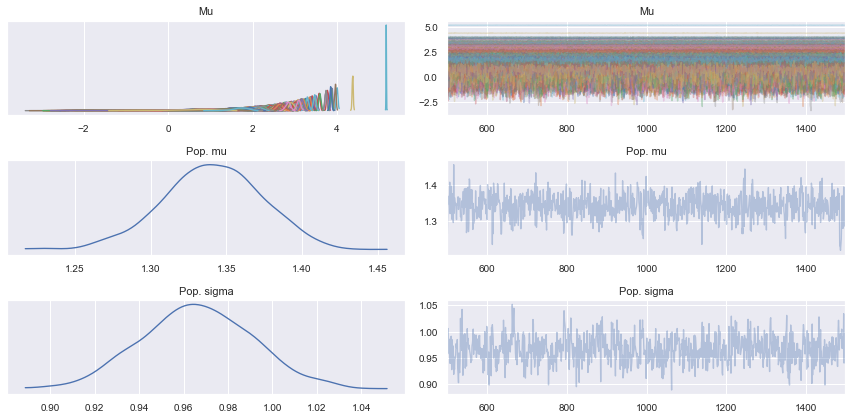

In [170]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = np.log(means)
controller._initial_params[0, 0, -2:] = np.array([1.3, 1])
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [171]:
exact_posterior_samples.to_netcdf(
    'derived_data/posteriors/hierarchical_exponential_model_hierarchical.nc')

In [5]:
exact_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/hierarchical_exponential_model_hierarchical.nc')

### 2. Gaussian filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     10     0.5      4        0:00.0
1     11     0.25     1        0:00.0
2     12     0.25     1        0:00.0
3     13     0.5      1        0:00.0
20    135    0.768    7        0:00.2
40    428    0.76     14       0:00.3
60    4525   0.673    196      0:02.3
80    14185  0.782    460      0:06.7
100   21908  0.763    368      0:10.3
120   29424  0.723    358      0:14.2
140   38139  0.768    415      0:18.1
160   47395  0.718918 441      0:22.3
180   58157  0.751    513      0:27.7
200   66398  0.779    393      0:31.5
220   71785  0.759    257      0:34.3
240   78593  0.737    325      0:37.3
260   85473  0.747    328      0:40.3
280   94321  0.727    422      0:44.3
300   100919  0.761    315      0:47.5
320   110005  0.769    433      0:51.5
340   115803  0.751    277      0:54.1
360   125907  0.737    482      0:59.2
380   137375  0.797    547      1:05.8
400   142548 

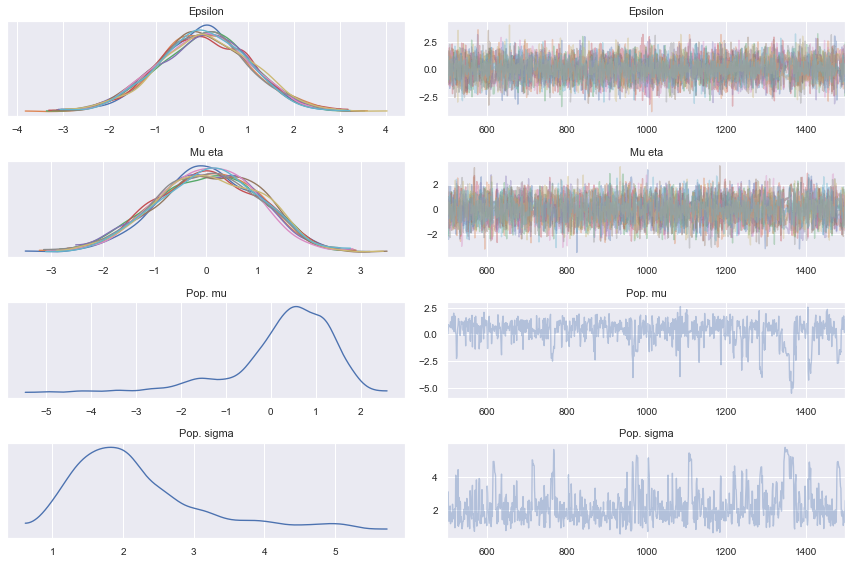

In [20]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.375    2        0:00.0
1     7      0.25     1        0:00.0
2     8      0.25     1        0:00.0
3     9      0.25     1        0:00.0
20    10429  0.744    579      0:12.2
40    21523  0.755943 529      0:25.5
60    30294  0.779    418      0:35.9
80    38152  0.754    375      0:45.6
100   46726  0.749    408      0:57.6
120   51511  0.732    228      1:04.3
140   55704  0.738    200      1:10.3
160   59034  0.732    159      1:15.0
180   62526  0.768    167      1:19.6
200   65394  0.745    137      1:23.0
220   68330  0.744    140      1:26.7
240   70547  0.769    106      1:29.7
260   72859  0.732    110      1:32.8
280   76635  0.766    180      1:37.0
300   81334  0.746753 224      1:42.3
320   83909  0.774    123      1:45.2
340   86733  0.755    135      1:48.4
360   89151  0.746    116      1:51.1
380   91596  0.756    117      1:54.5
400   94016  0.771

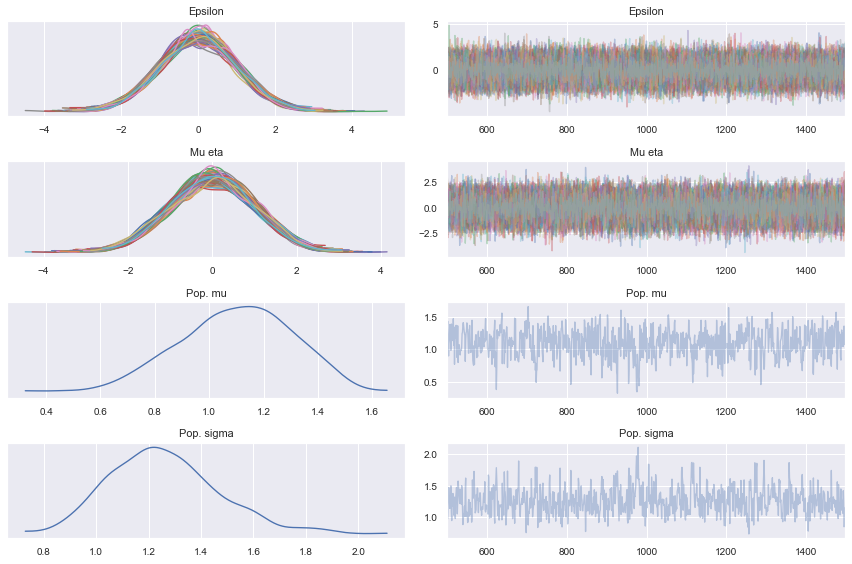

In [22]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.5      2        0:00.1
1     7      0.25     1        0:00.1
2     8      0.25     1        0:00.1
3     9      0.25     1        0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    8165   0.755196 454      1:16.7
40    19562  0.733    543      2:57.1
60    31205  0.75     555      4:38.3
80    43073  0.77     566      6:23.1
100   52894  0.775819 468      7:50.4
120   54642  0.707    84       8:05.2
140   56725  0.778    100      8:23.0
160   58476  0.727    84       8:37.8
180   60388  0.759    92       8:54.1
200   61627  0.746    59       9:04.5
220   62913  0.769376 62       9:15.2
240   64305  0.746    67       9:27.7
260   65778  0.738    70       9:41.1
280   67622  0.733    88       9:57.2
300   69399  0.766    85      10:11.3
320   70645  0.753    60      10:21.4
340   72061  0.778    68      10:33.1
360   73413  0.751    65      10:43.6
380   74801  0.768    67      10:54.9
400   76218  0.745    68      11:08.4
420   77572  0.753449 65      11:19.0
440   78840  0.762    61      11:29.0
460   79806  0.707    46      11:36.6
480   81283  0.765    71      11:48.1
500   83006  0.738    83      12:02.7
520   84266  0.84     60      12:13.9
540   85526 

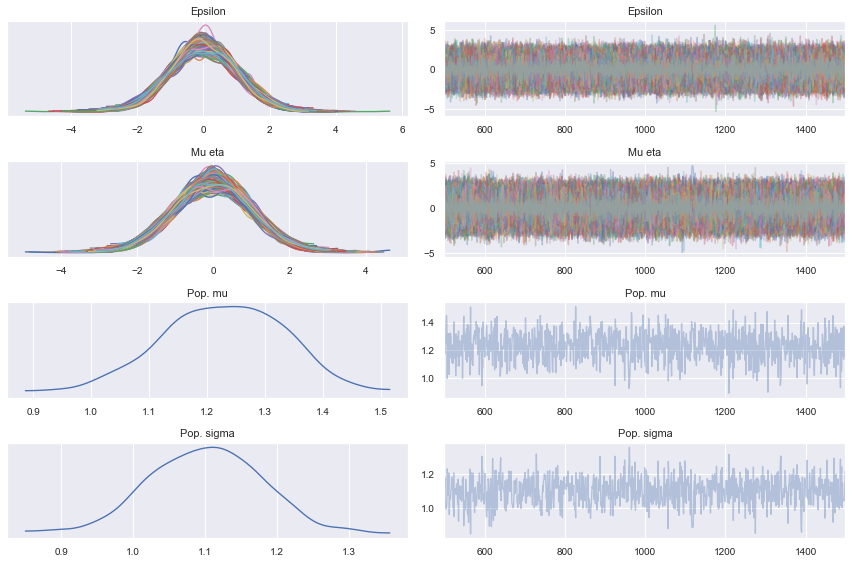

In [31]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [32]:
gaussian_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_exponential_model_gaussian_filter_1000.nc')

### 3. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     19     0.217    8        0:00.0
1     22     0.25     2        0:00.0
2     25     0.5      2        0:00.0
3     28     0.125    2        0:00.0
20    6029   0.783    334      0:06.3
40    15871  0.751    469      0:16.3
60    22159  0.767    300      0:22.7
80    28239  0.755    290      0:28.5
100   34679  0.745    307      0:33.9
120   41235  0.713    313      0:39.5
140   47749  0.767    311      0:45.1
160   53316  0.737    265      0:49.9
180   57972  0.767    222      0:53.9
200   63391  0.764    259      0:58.6
220   68351  0.727    237      1:04.3
240   72840  0.774    214      1:09.3
260   76401  0.729    170      1:12.8
280   81507  0.764    244      1:18.8
300   85503  0.740375 191      1:22.5
320   88721  0.768    154      1:25.7
340   92589  0.774    185      1:29.6
360   98033  0.751    260      1:35.5
380   101139  0.757725 148      1:38.3
400   104727  0.7

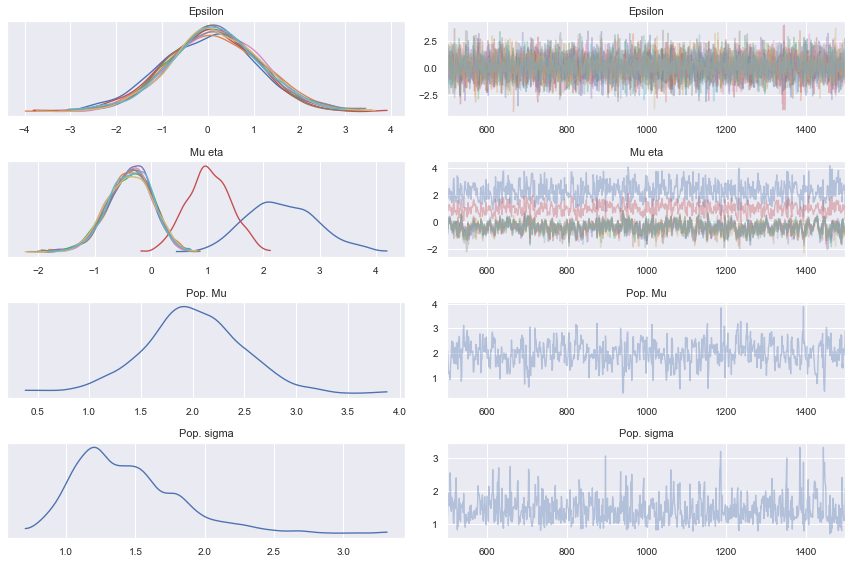

In [36]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     20     0.244    8        0:00.1
1     23     0.5      2        0:00.1
2     26     0.125    2        0:00.2
3     148    0.356    61       0:00.8
20    12597  0.753    692      0:54.3
40    26973  0.737    685      1:51.0
60    41343  0.776    685      2:47.8
80    57131  0.768618 752      3:50.0
100   70586  0.742    641      4:42.2
120   78082  0.731    357      5:11.4
140   84654  0.752956 313      5:37.1
160   88371  0.724    177      5:51.6
180   90401  0.74     97       5:59.6
200   92279  0.767    90       6:07.3
220   93899  0.752    78       6:13.6
240   95578  0.758    80       6:20.2
260   97556  0.71     94       6:27.8
280   99838  0.753    109      6:36.7
300   102020  0.759    104      6:45.1
320   103745  0.734    83       6:51.8
340   105933  0.774    105      7:00.7
360   107800  0.732    89       7:08.1
380   110020  0.781    106      7:16.8
400   111846 

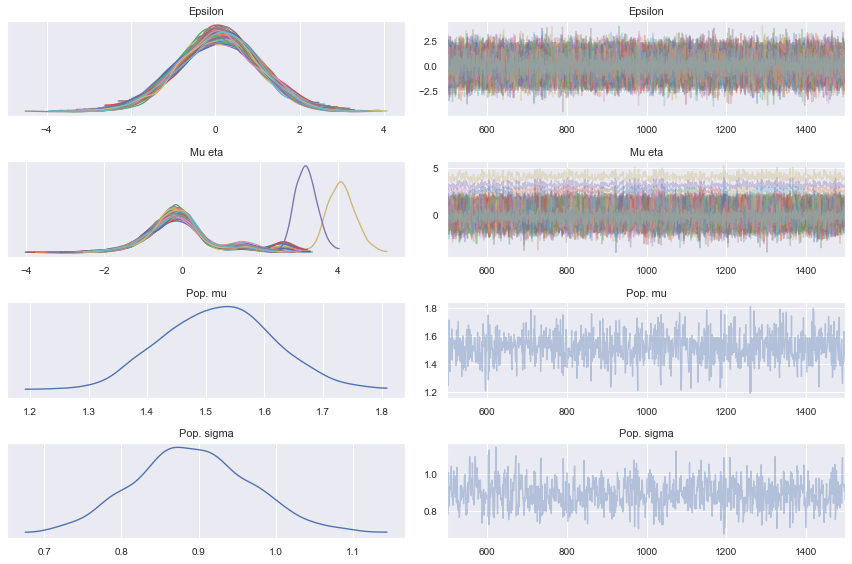

In [43]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [44]:
gaussian_kde_filter_100_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_exponential_model_gaussian_kde_filter_100.nc')

1000 samples

In [ ]:
n_samples = 500
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_500_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_500_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

### 4. Rank matching Gaussian KDE likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     7      0.36     2        0:00.0
1     8      0.25     1        0:00.0
2     10     0.167    1        0:00.0
3     13     0.326    2        0:00.0
20    259    0.76     14       0:00.1
40    1915   0.739    79       0:00.6
60    4273   0.767    113      0:01.1
80    6811   0.785    121      0:01.7
100   9043   0.756    106      0:02.3
120   10095  0.724    51       0:02.6
140   12489  0.76     114      0:03.2
160   13683  0.717    57       0:03.5
180   15431  0.761    84       0:04.0
200   17729  0.732    110      0:04.5
220   19951  0.779    106      0:05.0
240   22847  0.764    138      0:05.7
260   24527  0.714    80       0:06.1
280   26417  0.748    90       0:06.6
300   29475  0.75     146      0:07.3
320   31143  0.772    80       0:07.7
340   32953  0.750096 87       0:08.2
360   35371  0.757    116      0:08.7
380   38681  0.769    158      0:09.5
400   40411  0.746

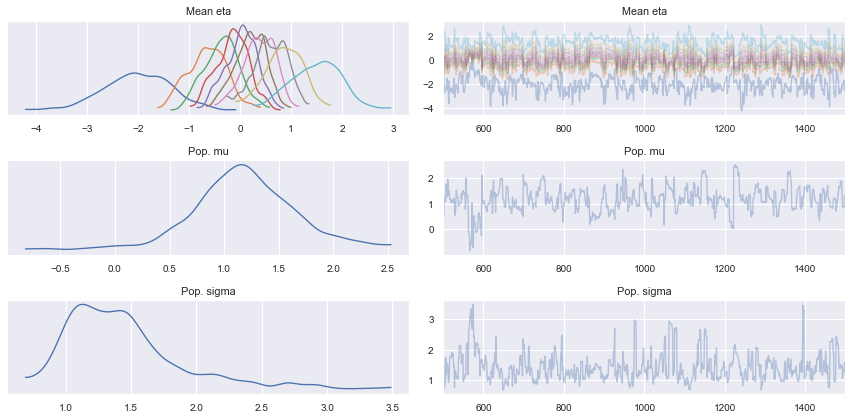

In [63]:
n_samples = 10
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    rmg_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     9      0.228    2        0:00.0
1     10     0.25     1        0:00.0
2     11     0.25     1        0:00.0
3     17     0.224    3        0:00.0
20    968    0.69     53       0:00.7
40    9928   0.764    427      0:06.6
60    16606  0.750065 318      0:10.7
80    24273  0.745    366      0:14.6
100   30425  0.739    293      0:17.7
120   31857  0.702372 69       0:18.4
140   33822  0.787    94       0:19.4
160   34821  0.718    48       0:19.9
180   35811  0.754    48       0:20.4
200   36652  0.759946 41       0:20.9
220   37531  0.75     42       0:21.3
240   38372  0.755289 41       0:21.7
260   39337  0.722409 46       0:22.2
280   40674  0.751    64       0:22.9
300   41724  0.736    50       0:23.4
320   43120  0.778    67       0:24.1
340   44483  0.746    65       0:24.8
360   45845  0.765    65       0:25.5
380   46942  0.748    53       0:26.0
400   48068  0.746

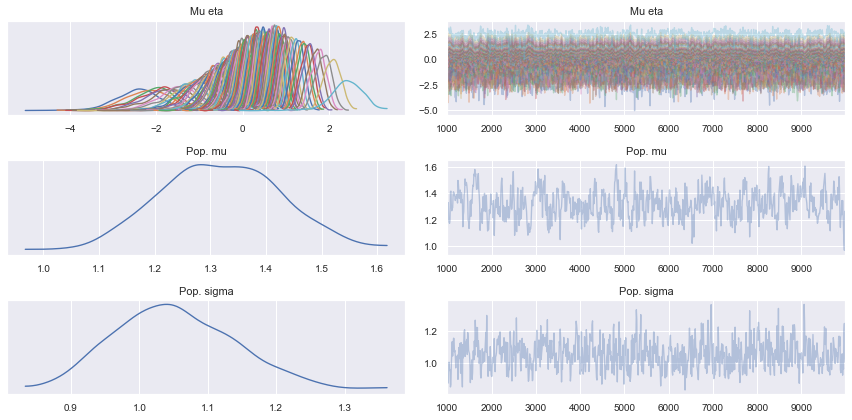

In [67]:
n_samples = 100
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 10000
rmg_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=1000
thinning=10
az.plot_trace(
    rmg_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

500 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     13     0.5      2        0:00.1
1     14     0.25     1        0:00.1
2     15     0.25     1        0:00.1
3     18     0.5      2        0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    83     0.761    4        0:00.3
40    222    0.777    7        0:00.6
60    346    0.769    6        0:00.8
80    456    0.735478 6        0:01.0
100   1411   0.772    46       0:02.8
120   8784   0.738    352      0:16.7
140   21721  0.746    617      0:40.7


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:331: RuntimeWarning: overflow encountered in exp


160   31710  0.705    476      0:59.1
180   40916  0.761    439      1:16.0
200   50374  0.754    451      1:33.7
220   59335  0.774    427      1:50.0
240   67797  0.741    403      2:05.2
260   72712  0.719    234      2:14.1
280   74236  0.749    73       2:16.8
300   76039  0.774    86       2:20.1
320   77412  0.741    66       2:22.7
340   78800  0.739    67       2:25.2
360   80338  0.791    74       2:28.1
380   81675  0.724    64       2:30.5
400   82980  0.766    63       2:33.5
420   84346  0.760645 66       2:36.1
440   85645  0.742869 62       2:38.8
460   86872  0.73     59       2:42.0
480   88381  0.758    72       2:45.6
500   90289  0.773    91       2:49.9
520   91549  0.896    60       2:52.6
540   92809  0.849    60       2:55.8
560   94069  0.892    60       2:58.6
580   95329  0.89     60       3:01.1
600   96589  0.875    60       3:03.5
620   97849  0.904    60       3:06.2
640   99109  0.877416 60       3:08.7
660   100369  0.822    60       3:11.2
680   10162

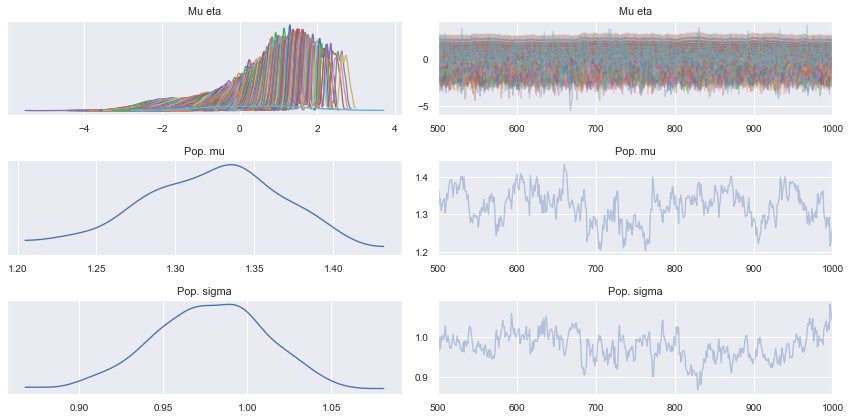

In [87]:
n_samples = 500
log_likelihood = RankMatchingGaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4),
    pints.HalfCauchyLogPrior(location=1, scale=2)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
rmg_kde_filter_500_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    rmg_kde_filter_500_posterior_samples.sel(
        draw=slice(warmup, 1000, thinning)))
plt.tight_layout()

In [88]:
rmg_kde_filter_500_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_exponential_model_rm_gaussian_kde_filter_500.nc')

## Comparison to analytic posterior

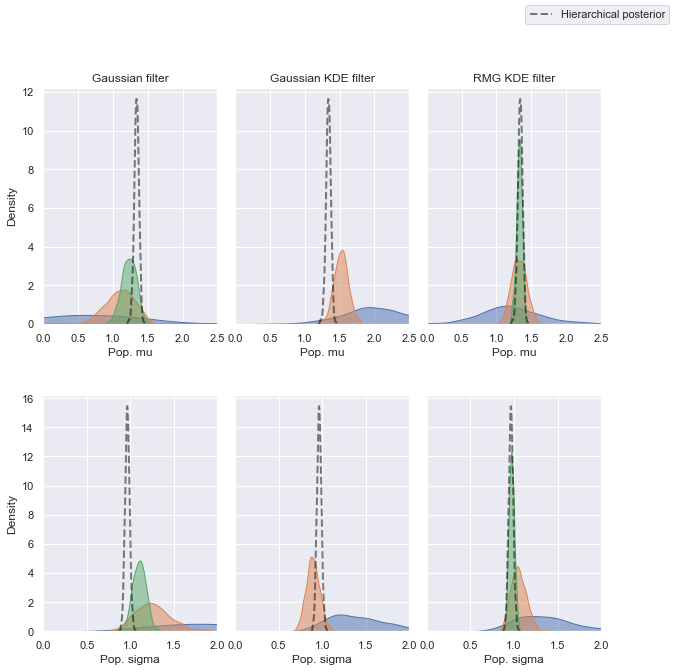

In [89]:
# Create figure
fig, axes = plt.subplots(
    2, 3, figsize=(10, 10), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0, 0].set_xlim([0, 2.5])
axes[1, 0].set_xlim([0, 2])
axes[0, 0].set_xlabel('Pop. mu')
axes[0, 1].set_xlabel('Pop. mu')
axes[0, 2].set_xlabel('Pop. mu')
axes[1, 0].set_xlabel('Pop. sigma')
axes[1, 1].set_xlabel('Pop. sigma')
axes[1, 2].set_xlabel('Pop. sigma')
axes[0, 0].set_title('Gaussian filter')
axes[0, 1].set_title('Gaussian KDE filter')
axes[0, 2].set_title('RMG KDE filter')
colors = sns.color_palette()

# Plot Gaussian filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 0],
    palette=colors[1], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 0],
    palette=colors[0], legend=False)

# Plot Gaussian KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. Mu'].values[0]
sigma_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 1],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 1],
    palette=colors[0], legend=False)

# Plot RMG KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = rmg_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
    palette=colors[0], legend=False)

warmup = 1000
thinning = 10
mu_samples = rmg_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, 10000, thinning))['Pop. mu'].values[0]
sigma_samples = rmg_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, 10000, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = rmg_kde_filter_500_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = rmg_kde_filter_500_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0, 2],
    palette=colors[0], legend=False)
sns.kdeplot(
    x=sigma_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1, 2],
    palette=colors[0], legend=False)

# Overlay hierarchical likelihood inference
warmup = 500
thinning = 1
mu_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mu'].values[0]
sigma_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. sigma'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[0, 0],
    color='black', linestyle='--', label='Hierarchical posterior')
sns.kdeplot(
    x=sigma_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[1, 0],
    color='black', linestyle='--')
sns.kdeplot(
    x=mu_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[0, 1],
    color='black', linestyle='--')
sns.kdeplot(
    x=sigma_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[1, 1],
    color='black', linestyle='--')
sns.kdeplot(
    x=mu_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[0, 2],
    color='black', linestyle='--')
sns.kdeplot(
    x=sigma_samples,
    fill=False,
    common_norm=False, alpha=.5, linewidth=2, ax=axes[1, 2],
    color='black', linestyle='--')

fig.legend()
# plt.tight_layout()
plt.show()